In [193]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import DensityMatrix, random_clifford, Statevector, Operator, random_density_matrix, state_fidelity
from qiskit_aer import AerSimulator
from qiskit.circuit.library import IGate, XGate, YGate, ZGate
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Estimator, Session

from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian
from qiskit.visualization import plot_histogram


from tqdm import tqdm
from scipy.linalg import eigh, sqrtm

from qiskit.visualization import plot_state_city
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


In [194]:
def make_clifford(n):
    cir=QuantumCircuit(2)
    cir.h(0)
    cir.cx(0,1)
    cir_main = QuantumCircuit(2)
    for i in range(n):
        clif = random_clifford(2)
        cir_main.append(clif,[0,1])
    U=Operator(cir_main)
    cir_uni = QuantumCircuit(2,2)
    cir_uni.unitary(U,[0,1])

    trans_qc = transpile(cir_uni, basis_gates=['cx','u3'])
    cir=cir.compose(trans_qc, [0,1])
    return cir, U

In [176]:
# running on hardware 
service = QiskitRuntimeService(channel="ibm_quantum", token="")
backend = service.least_busy(operational=True, simulator=False)
 
print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"No. of qubits: {backend.num_qubits}\n"
)


Name: ibm_kyiv
Version: 2
No. of qubits: 127



In [195]:
def split_result(num, string, count, result = [{'00':0, '01':0, '10':0, '11':0} for i in range(50)]):
    
    if num*2 != len(string):
        print("ERROR")
    
    for i in range(num):
        result[i][string[2*i:2*i+2]] += count
    return result

def reconstruct_density(num_qubit, U, basis_string):
    basis = Statevector.from_label(basis_string).data.reshape(1,-1)
    basis = basis * basis.T
    rho = (2**(num_qubit) + 1) * U.data.conj().T @ basis @ U.data - np.eye(2**num_qubit) 
    return rho 

In [196]:
def get_density(sync, backend):
    sync=sync
    cir_list = []
    U_list = []
    for i in range(sync):
        cir, U = make_clifford(1)
        cir_list.append(cir)
        U_list.append(U)
    
    new_cir = QuantumCircuit(20,20)
    for i in range(sync):
        new_cir = new_cir.compose(cir_list[i],[2*i,2*i+1])
    
    new_cir.measure_all()
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    isa_circuit = pm.run(new_cir)
    
    sampler = Sampler(backend)
    job = sampler.run([isa_circuit])
    result = job.result()
    result = result[0].data.meas.get_counts()

    temp = [{'00':0, '01':0, '10':0, '11':0} for i in range(sync)]
    for i in result:
        temp = split_result(sync,i,result[i],temp)
        
    rho_list=[]
    for i in range(sync):
        rho_list += [reconstruct_density(2,U_list[0], '00') for i in range(temp[i]['00'])]
        rho_list += [reconstruct_density(2,U_list[0], '01') for i in range(temp[i]['01'])]
        rho_list += [reconstruct_density(2,U_list[0], '10') for i in range(temp[i]['10'])]
        rho_list += [reconstruct_density(2,U_list[0], '11') for i in range(temp[i]['11'])]

    return rho_list


In [ ]:
rho_list = []
rho_result=[]
for i in range(30):
    rho_list += get_density(10,backend)
    rho_result.append(sum(rho_list)/len(rho_list))
    print(calculate_fidelity(DensityMatrix(rho_result[-1]),Statevector(1/np.sqrt(2)*np.array([1,0,0,1]))))
    print(calculate_trace_distance(rho_result[-1],rho_bell.data))

0.2499999999999999
0.55706787109375
0.2851562499999999
0.4815148219465095
0.2734374999999999
0.46971738738952784
0.33334350585937494
0.4128563886897115
0.3442504882812499
0.3894603274966685
0.3285420735677082
0.39062024522892935


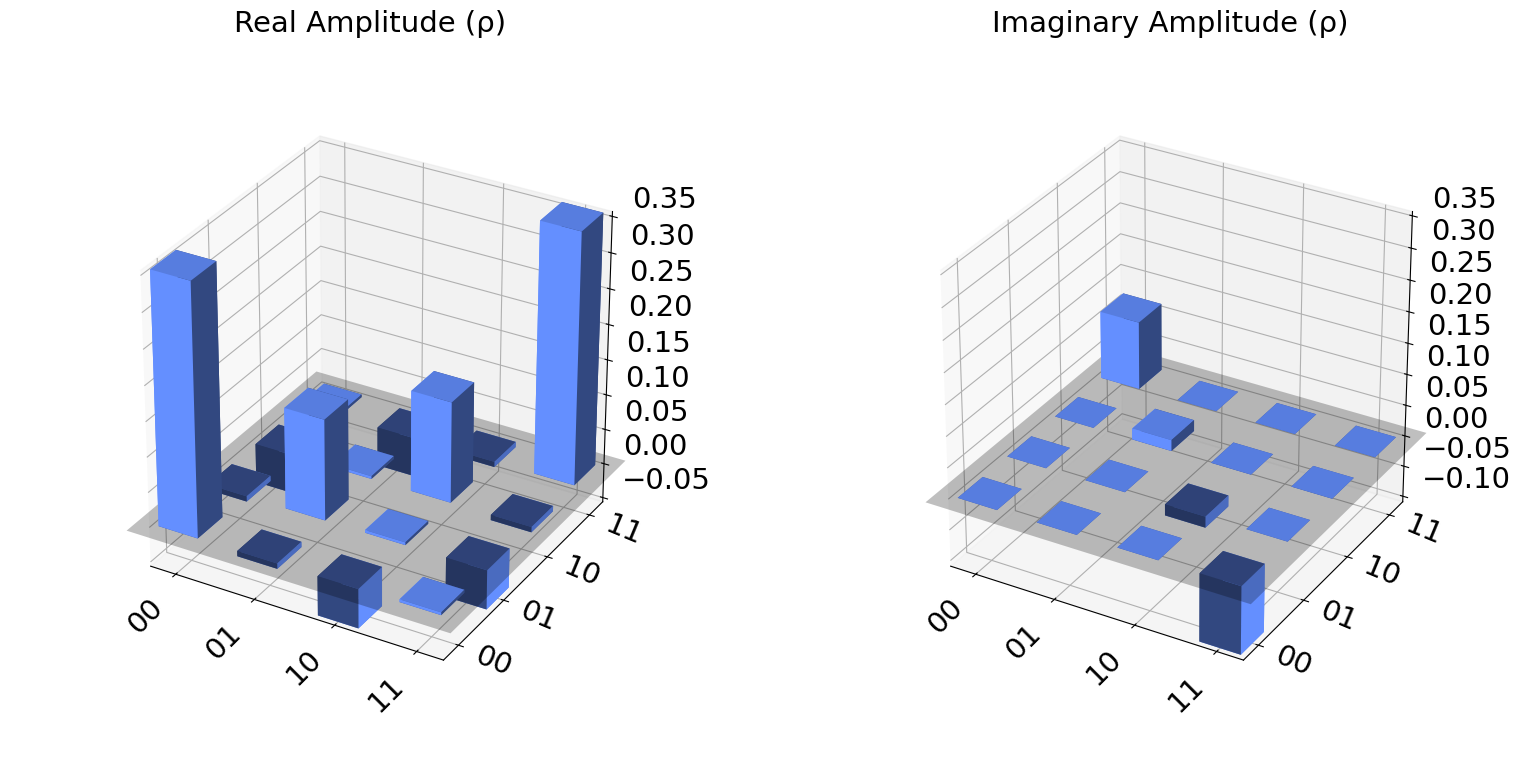

In [215]:
plot_state_city(rho_result[1])

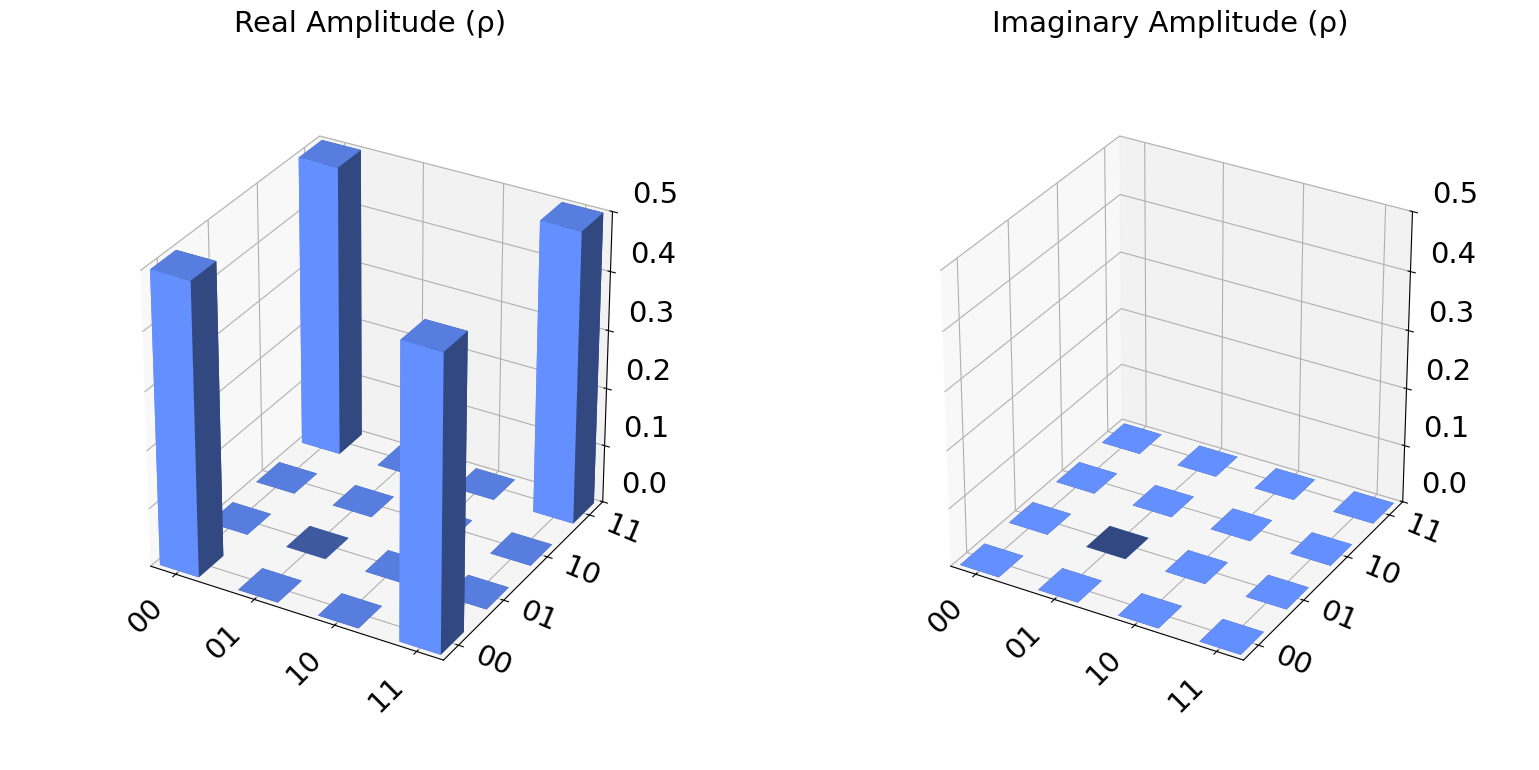

In [184]:
plot_state_city(rho_bell)

In [166]:
rho_bell = DensityMatrix(np.array([[0.5, 0, 0, 0.5],
                                   [0,0,0,0],
                                   [0,0,0,0],
                                   [0.5, 0, 0, 0.5]]))

40960


0.2499999999999999


0.56060791015625

In [125]:
def calculate_fidelity(rho, psi): # rho : density matrix, psi : State vector
    return np.real(psi.data @ rho.data @ psi.data.T)

def calculate_trace_distance(rho1, rho2): # rho : density matrix
    return np.linalg.norm(rho1-rho2, ord=1)*0.5

In [88]:
temp[0].values()

dict_values([1959, 14, 2081, 42])

In [83]:
temp

[{'00': 1959, '01': 14, '10': 2081, '11': 42},
 {'00': 1964, '01': 7, '10': 2114, '11': 11},
 {'00': 1679, '01': 2129, '10': 74, '11': 214},
 {'00': 22, '01': 3978, '10': 48, '11': 48},
 {'00': 955, '01': 996, '10': 1024, '11': 1121},
 {'00': 115, '01': 1999, '10': 113, '11': 1869},
 {'00': 1121, '01': 1253, '10': 691, '11': 1031},
 {'00': 999, '01': 1040, '10': 936, '11': 1121},
 {'00': 1186, '01': 917, '10': 1134, '11': 859},
 {'00': 2186, '01': 42, '10': 1810, '11': 58},
 {'00': 989, '01': 1195, '10': 1116, '11': 796},
 {'00': 39, '01': 108, '10': 60, '11': 3889},
 {'00': 187, '01': 1961, '10': 1848, '11': 100},
 {'00': 43, '01': 46, '10': 2025, '11': 1982},
 {'00': 170, '01': 1915, '10': 396, '11': 1615},
 {'00': 1283, '01': 976, '10': 855, '11': 982},
 {'00': 942, '01': 930, '10': 1186, '11': 1038},
 {'00': 106, '01': 2026, '10': 87, '11': 1877},
 {'00': 82, '01': 1963, '10': 1996, '11': 55},
 {'00': 1270, '01': 825, '10': 907, '11': 1094},
 {'00': 1916, '01': 46, '10': 269, '11':

In [ ]:
# for bell state classical shadow
class Classical_shadow:
    def __init__(self, sample_N):
        self.num_qubits = 2 
        self.circuit = QuantumCircuit(self.num_qubits)
        self.operator_lists = None
        self.sample_N = sample_N
        self.group_K = None
        self.unitary_N = None
        self.random_method = None
        self.random_unitary = None
        self.individual_unitary = None # For random pauli
        self.rho_list=[]
        self.group_rho_list=[]
        self.trace_data=None
        
    def get_random_unitary(self, method): # method = "pauli", "n-clifford", "user-defined"
        # return : (operator, qubits : list)
        if method == "n-clifford":
            applied_qubit = np.arange(self.num_qubits)
            random_unitary = random_clifford(self.num_qubits)
            return (random_unitary, list(applied_qubit))

    def add_random_unitary(self, method, unitary_N):
        self.random_method = method
        self.unitary_N = unitary_N
        for i in range(unitary_N):
            temp = self.get_random_unitary(method)
            self.circuit.append(temp[0], temp[1])
                
        # Calculate circuit unitary matrix
        self.random_unitary = Operator(self.circuit)
        
        # make bell state
        self.circuit.h(0)
        self.circuit.cx(0,1)
        self.circuit = init.compose(self.circuit, list(range(self.num_qubits)))
        
    def reconstruct_density(self, method, unitary_N):
        self.add_random_unitary(method, unitary_N)
        simulator = AerSimulator()
        self.circuit.measure_all()
        transpiled_qc = transpile(self.circuit, simulator)
        result = simulator.run(transpiled_qc, shots=1).result()

        if method == "n-clifford":
            basis = Statevector.from_label(list(result.get_counts().keys())[0]).data.reshape(1,-1)
            basis = basis * basis.T
            rho = (2**(self.num_qubits) + 1) * self.random_unitary.data.conj().T @ basis @ self.random_unitary.data - np.eye(2**self.num_qubits) 
            return rho

    def get_reconstruct_density(self, method, unitary_N, nearest=True):
        result = []
        temp = []
        for i in tqdm(range(self.sample_N)):
            self.initialize()
            temp.append(self.reconstruct_density(method, unitary_N))
            if nearest:
                result.append(nearest_density_matrix(sum(temp)/len(temp)))
            else:
                result.append(sum(temp)/len(temp))
        return result
    
    def prediction_multi(self, method, unitary_N, observable_list, K):
        self.trace_data = []
        
        self.group_K = K
        for i in tqdm(range(self.sample_N)):
            self.initialize()
            self.rho_list.append(self.reconstruct_density(method, unitary_N))

        group_n = self.sample_N // K
        temp=0.0
        for i in range(group_n):
            for j in range(K):
                temp=temp+self.rho_list[i*K+j]
            self.group_rho_list.append(temp/K)
            temp=0.0

        result=[]

        for ind, observable in enumerate(observable_list):
            temp=[]
            for i in self.group_rho_list:
                temp.append(np.trace(i @ observable))
            self.trace_data.append(np.array(temp, dtype=float))
            result.append(np.median(np.array(temp,dtype=float)))

        return result
    
    def prediction(self, method, unitary_N, observable, K):
        self.group_K = K
        for i in tqdm(range(self.sample_N)):
            self.initialize()
            self.rho_list.append(self.reconstruct_density(method, unitary_N))

        group_n = self.sample_N // K
        temp=0.0
        for i in range(group_n):
            for j in range(K):
                temp=temp+self.rho_list[i*K+j]
            self.group_rho_list.append(temp/K)
            temp=0.0

        temp=[]
        for i in self.group_rho_list:
            temp.append(np.trace(i @ observable))
        self.trace_data = np.array(temp, dtype=float)

        return np.median(np.array(temp,dtype=float))

    def initialize(self):
        self.circuit = QuantumCircuit(self.num_qubits)
        
    def draw_circuit(self):
        return self.circuit.draw()
        

In [4]:
# global variables

# Define |0> and |1>
ket_0 = np.array([[1,0]]).T
ket_1 = np.array([[0,1]]).T

In [5]:
def measure_by_clifford(phi, num_qubit, num_clifford):
    """
    After applying Clifford operation on rho, obtain measurement in the computational basis
    """
    # Use the Clifford class of Paddle Quantum to randomly select a Clifford operator and generate its circuit
    cir = QuantumCircuit(num_qubit)

    cir_init = QuantumCircuit(num_qubit)
    # cir_init.set_density_matrix(phi)

    for i in range(num_clifford):
        clif = random_clifford(num_qubit)
        # Run the circuit
        cir.append(clif, list(np.arange(num_qubit)))

    # Get the unitary implemented by the circuit
    cl = Operator(cir).data
    
    cir_init.unitary(cl, [0,1])
    
    cir = cir_init.compose(cir, list(range(num_qubit)))
    # cir.save_statevector()


    # Single measurement
    simulator = AerSimulator()
    cir.measure_all()
    transpiled_qc = transpile(cir, simulator)
    result = simulator.run(transpiled_qc, shots=1).result()
    bitstring = [k for k, v in result.get_counts().items() if v == 1.0]

    # Use this to record results of measurement
    bhat = [[1.]]
    for i in bitstring[0]:
        if i == '0':
            bhat = np.kron(bhat, ket_0)
        elif i == '1':
            bhat = np.kron(bhat, ket_1)

    return bhat, cl, cir



In [6]:
# Number of qubits
n_qubit = 2

# condition for werner state : 
p = 1/3

# Randomly generate a state
rho_random = random_density_matrix((2,)*n_qubit)

rho_bell = DensityMatrix(np.array([[0.5, 0, 0, 0.5],
                                   [0,0,0,0],
                                   [0,0,0,0],
                                   [0.5, 0, 0, 0.5]]))

rho_werner = DensityMatrix(np.array([[(1-p)/4, 0, 0 ,0],
                                     [0,((1-p)+2*p)/4, (-2*p)/4, 0],
                                     [0, (-2*p)/4, ((1-p)+2*p)/4, 0],
                                     [0, 0, 0, (1-p)/4]]))


# Define I and coefficient
I = np.eye(2**n_qubit)
coefficient = float(2**n_qubit + 1)

In [7]:

# running on hardware 
service = QiskitRuntimeService(channel="ibm_quantum", token="")
backend = service.least_busy(operational=True, simulator=False)
service.backends()
backend

<IBMBackend('ibm_kyiv')>

In [8]:
backend = service.backend("ibm_osaka")
 
print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"No. of qubits: {backend.num_qubits}\n"
)

Name: ibm_osaka
Version: 2
No. of qubits: 127



In [9]:
phi = rho_werner
num_qubit = 2
num_clifford = 3


bhat, cl, cir = measure_by_clifford(phi, num_qubit, num_clifford)
print(cl)
print(cir)


# mat = np.real(random_hermitian(num_qubit, seed=1234))
# circuit = IQP(mat)
observableZ = SparsePauliOp("Z" * num_qubit)

print(f">>> Observable: {observableZ.paulis}")


[[-0.35355339-0.35355339j -0.35355339-0.35355339j  0.35355339+0.35355339j
  -0.35355339-0.35355339j]
 [-0.35355339-0.35355339j -0.35355339-0.35355339j -0.35355339-0.35355339j
   0.35355339+0.35355339j]
 [-0.35355339-0.35355339j  0.35355339+0.35355339j -0.35355339-0.35355339j
  -0.35355339-0.35355339j]
 [ 0.35355339+0.35355339j -0.35355339-0.35355339j -0.35355339-0.35355339j
  -0.35355339-0.35355339j]]
        ┌──────────┐┌───────────┐┌───────────┐┌───────────┐ ░ ┌─┐   
   q_0: ┤0         ├┤0          ├┤0          ├┤0          ├─░─┤M├───
        │  Unitary ││  Clifford ││  Clifford ││  Clifford │ ░ └╥┘┌─┐
   q_1: ┤1         ├┤1          ├┤1          ├┤1          ├─░──╫─┤M├
        └──────────┘└───────────┘└───────────┘└───────────┘ ░  ║ └╥┘
meas: 2/═══════════════════════════════════════════════════════╩══╩═
                                                               0  1 
>>> Observable: ['ZZ']


In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(cir)
isa_circuit.draw()


global phase: π
                   ┌─────────┐┌────┐┌─────────────┐┌────┐┌──────────┐┌──────┐»
          q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(-2.9374) ├┤ √X ├┤ Rz(-π/2) ├┤1     ├»
                   └┬────────┤├────┤└──┬────────┬─┘└────┘└──────────┘│  Ecr │»
          q_1 -> 1 ─┤ Rz(-π) ├┤ √X ├───┤ Rz(-π) ├────────────────────┤0     ├»
                    └────────┘└────┘   └────────┘                    └──────┘»
    ancilla_0 -> 2 ──────────────────────────────────────────────────────────»
                                                                             »
    ancilla_1 -> 3 ──────────────────────────────────────────────────────────»
                                                                             »
    ancilla_2 -> 4 ──────────────────────────────────────────────────────────»
                                                                             »
    ancilla_3 -> 5 ──────────────────────────────────────────────────────────»
                                                                             »
    ancilla_4 -> 6 ──────────────────────────────────────────────────────────»
                                                                             »
    ancilla_5 -> 7 ──────────────────────────────────────────────────────────»
                                                                             »
    ancilla_6 -> 8 ──────────────────────────────────────────────────────────»
                                                                             »
    ancilla_7 -> 9 ──────────────────────────────────────────────────────────»
                                                                             »
   ancilla_8 -> 10 ──────────────────────────────────────────────────────────»
                                                                             »
   ancilla_9 -> 11 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_10 -> 12 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_11 -> 13 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_12 -> 14 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_13 -> 15 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_14 -> 16 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_15 -> 17 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_16 -> 18 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_17 -> 19 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_18 -> 20 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_19 -> 21 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_20 -> 22 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_21 -> 23 ──────────────────────────────────────────────────────────»
                                                                             »
  ancilla_22 -> 24 ──────────────────────────────────────────────────────────»
                                  

In [11]:
sampler = Sampler(backend)

job = sampler.run([isa_circuit])

result = job.result()



In [12]:
result[0]

PubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})

In [13]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import random_hermitian

pub_result = result[0]
print(pub_result)
print(pub_result.data)
print(f"Counts for the meas output register: {pub_result.data.meas.get_counts()}")

PubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})
DataBin(meas=BitArray(<shape=(), num_shots=4096, num_bits=2>))
Counts for the meas output register: {'01': 3698, '10': 73, '11': 83, '00': 242}


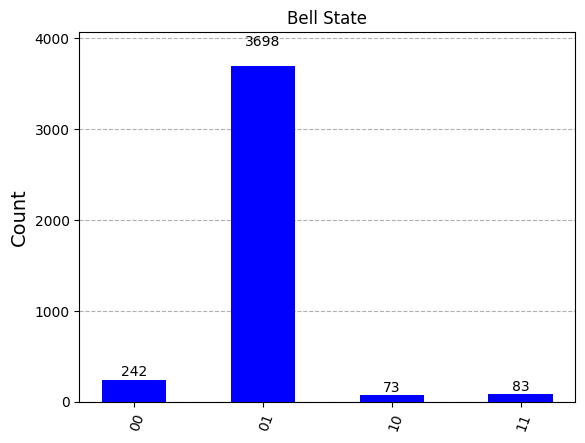

In [14]:
counts1 = pub_result.data.meas.get_counts()
plot_histogram([counts1], color=['blue'],
                title="Bell State")

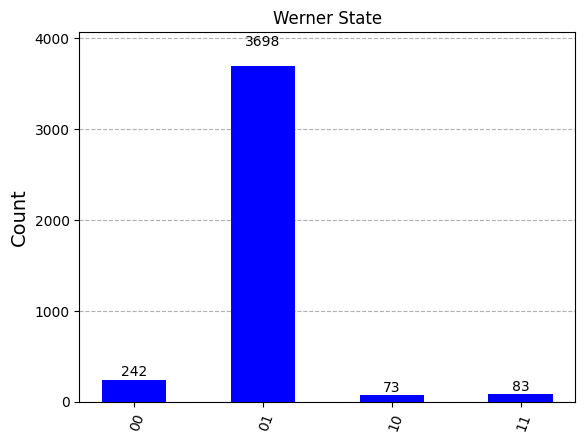

In [15]:
counts1 = pub_result.data.meas.get_counts()
plot_histogram([counts1], color=['blue'],
                title="Werner State")

In [16]:
from qiskit_aer import AerSimulator

qc_aer = transpile(isa_circuit)

backend = AerSimulator()
result = backend.run(isa_circuit, shots = 1).result()
counts = result.get_statevector()
# print(counts)

# plot_histogra/m([result[0].get_counts()], color='midnightblue', title="New Histogram")

QiskitError: 'No statevector for experiment "None"'